In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import serial, math, time
import simplefoc, simplefoc.commander
from simplefoc.registers import SimpleFOCRegisters as regs
from rx import operators as ops
import numpy as np

PORT="/dev/tty.usbmodem1441101"
BAUD=115200

sf = simplefoc.commander.serial(PORT, BAUD)
motor = sf.full_control('M')
sf.connect()
existingsub = None

In [2]:
console_display = display(display_id='console_display')
sf.console().pipe(
    ops.start_with("Welcome","to","SimpleFOC","Jupyter","Demo"),
    ops.buffer_with_count(5,1),
    ops.map(lambda x: '\n'.join(x))
).subscribe(lambda x: console_display.update({'text/plain': x}, raw=True))
None

MMS0000001
Monitor | 0000001
MMD100
Monitor | downsample: 100
ME0

In [3]:
telemetry_display = display(display_id='telemetry_display')
motor.set_monitoring([regs.REG_ANGLE])
motor.telemetry().pipe(
    ops.sample(1.0),
    ops.map(lambda x: [x.timestamp , x.values[0]])
).subscribe(telemetry_display.update)
motor.start_monitoring()
None

[1700523838.840339, 1.5472]

In [ ]:
motor.enable()
motor.set_target(0.5)

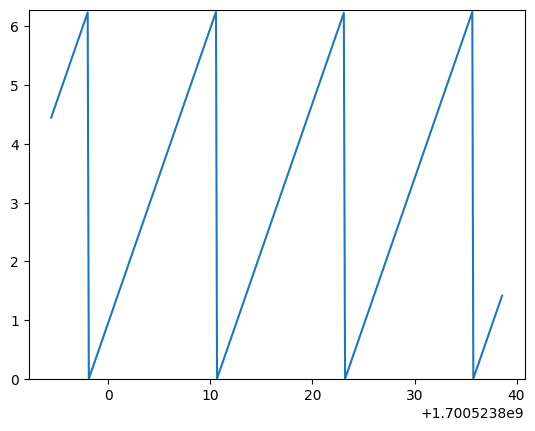

In [7]:
_2PI = 2 * math.pi
MAX_POINTS = 1000

fig, ax = plt.subplots()
x_data = []
y_data = []

fig_display = display(display_id='fig_display')

def draw_points(points):
    global x_data, y_data
    ax.clear()
    for p in points:
        x_data.append(p[0])
        y_data.append(p[1])
    if len(x_data)>MAX_POINTS:
        x_data = x_data[-MAX_POINTS:]
        y_data = y_data[-MAX_POINTS:]
    ax.plot(x_data, y_data)
    ax.set_ylim(0,_2PI)
    fig_display.update(fig)

global existingsub
if existingsub:
    existingsub.dispose()

existingsub = sf.telemetry().pipe(
    ops.sample(0.1),
    ops.map(lambda x: [x.timestamp, x.values[0]]),
    ops.buffer_with_count(5)
).subscribe(lambda x: draw_points(x))
plt.close()

In [8]:
motor.disable()
sf.disconnect()